# Preprocess

In [1]:
import torch
import torch.nn as nn
import numpy as np
import gensim

In [2]:
from src.preprocess import load_data, build_wordvec

data = 'sst1'
dataset = load_data(data)

for key, value in dataset.items():
    if key == 'w2i':
        print(f"Vocab size : {len(value)}")
    else:
        print(f"{key}\t: {value.size()}")

embed_mat = build_wordvec(dataset['w2i'], var=.01)
embed_mat.size()


Vocab size : 17895
train	: torch.Size([156817, 58])
train_label	: torch.Size([156817])
test	: torch.Size([2210, 58])
test_label	: torch.Size([2210])
dev	: torch.Size([1101, 58])
dev_label	: torch.Size([1101])


torch.Size([17895, 300])

In [8]:
emb = nn.Embedding(len(dataset['w2i']), 300)
filt = [3,4,5]
conv = nn.ModuleList([nn.Conv1d(1, 100, 300*k, stride=300, dtype=torch.float) for k in filt])
FC = nn.Linear(1 * 100 * 3, 2, dtype=torch.float)

input = dataset['train'][:5]
print(input.shape)
in_size = input.shape[1]
x = emb(input).view(-1, 1, 300*in_size)
print(x.shape)
conv_out = [con(x) for con in conv]
print([p.shape for p in conv_out])
pool_out = [nn.functional.max_pool1d(con, in_size - k + 1).view(-1,100)  for con, k in zip(conv_out, filt)]
print([p.shape for p in pool_out])
x = torch.cat(pool_out, 1)

x = FC(x)
print(x.shape)




torch.Size([5, 110])
torch.Size([5, 1, 33000])
[torch.Size([5, 100, 108]), torch.Size([5, 100, 107]), torch.Size([5, 100, 106])]
[torch.Size([5, 100]), torch.Size([5, 100]), torch.Size([5, 100])]
torch.Size([5, 2])


loss :  0.002: 100%|██████████| 5400/5400 [00:23<00:00, 231.07it/s]


Finished Training : 0:00:23 spent.
Accuracy of the Model on the 1000 test set: 91.90 %


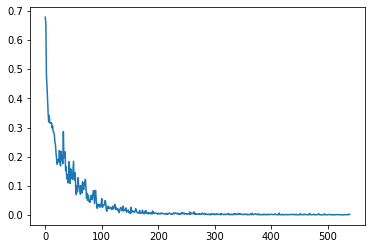

In [19]:
from src.trainer import Trainer
from src.model import CNN_TC

device = 'cuda:0'

model = CNN_TC('static', dataset, embed_mat, [3,4,5], 100, \
    dropout_ratio= .5, init=['he', None], bias=True, device=device).to(device)
criterion = nn.CrossEntropyLoss(weight=1 / torch.bincount(dataset['train_label']).to(torch.float).to(device))

optimizer = torch.optim.Adadelta(model.parameters(), lr=1, rho=.95, weight_decay=1e-8)
#optimizer = torch.optim.SGD(model.parameters(), lr=2e-6, weight_decay=.7)

trainer = Trainer(model, criterion, optimizer, dataset, l2=9, device = device)

## score= when l2=3
trainer.train(30, show_batches=10)
trainer.test()
trainer.plot()

In [24]:
from tqdm import tqdm
from src.model import CNN_TC
from src.trainer import Trainer
import torch.nn as nn
import torch
import numpy as np

device = 'cuda:0'
option = ['rand', 'static', 'nonstatic', 'multichannel'] # 'rand',
print(f"Tuning CNN in \"{data.upper()}\" set.")
for opt in option:
    
    model = CNN_TC(opt, dataset, embed_mat, [3,4,5], 100, \
    dropout_ratio= .5, init=[None, 'he'], bias=True, device=device).to(device)

    criterion = nn.CrossEntropyLoss()  # weight=len(data['train_label']) / torch.bincount(data['train_label']).to(torch.float)

    optimizer = torch.optim.Adadelta(model.parameters(), lr=1, rho=.95, weight_decay=0)
    trainer = Trainer(model, criterion, optimizer, dataset, l2=9, device=device)

    lst = []
    timeiter = tqdm(range(30), position=0, leave=True)
    m = 0
    for i in timeiter:
        trainer.train(1, show_batches=50, verbose=False)
        l = trainer.test(verbose=False)
        lst.append(l)
        m = max(m, l)
        timeiter.set_description(f"Acc : {100*l:.2f}, Max : {100*m:.2f}")
    #trainer.plot()
    Len = np.argmax(lst)
    print(f"Best Score for {opt.upper()} was {100*m:.2f} at {Len}^th epoch")
# drop = .3
## rho =.9  HN 92/89/90/90 NH 89/88/91/91
## rho =.95 HN 91/88/91/89 NH 90/89/91/89
# drop = .5
## rho =.9  HN 91/88/90/89 NH 90/89/90/
#### BH

Tuning CNN in "SST1" set.


Acc : 40.63, Max : 45.11: 100%|██████████| 30/30 [08:08<00:00, 16.27s/it]


Best Score for RAND was 45.11 at 2^th epoch


Acc : 41.49, Max : 46.29: 100%|██████████| 30/30 [04:00<00:00,  8.03s/it]


Best Score for STATIC was 46.29 at 7^th epoch


Acc : 40.68, Max : 48.87: 100%|██████████| 30/30 [08:07<00:00, 16.24s/it]


Best Score for NONSTATIC was 48.87 at 2^th epoch


Acc : 43.44, Max : 48.19: 100%|██████████| 30/30 [11:11<00:00, 22.37s/it]

Best Score for MULTICHANNEL was 48.19 at 0^th epoch


+ TEST Result

|       Model|SST1 |SST2 | CR  | MR  |TREC|MPQA |SUBJ|
|---         |---  |---  |---  |---  |--- |---  | ---|
|Random      |45.11|84.84|79.89|75.26|91.6|85.49|90.7|
|Static      |46.29|86.27|85.98|79.94|93.4|89.92|92.9|
|Non-Static  |48.87|88.25|85.87|81.44|94.2|89.92|93.5|
|MultiChannel|48.19|87.92|87.30|81.26|93.6|89.54|93.3|
|Should Be...|46.??|87.??|83.??|80.??|92.?|88.??|91.?|

In [6]:
model.embedding[1].weight[dataset['w2i'][wrd]]

tensor([ 0.2695,  0.0859,  0.0942,  0.0410, -0.1836,  0.1289,  0.0625, -0.1006,
         0.1484, -0.0659,  0.1367, -0.1904, -0.1226, -0.0591, -0.2949,  0.0850,
        -0.0226,  0.2041, -0.0515, -0.0330, -0.0806,  0.0262,  0.0276,  0.1011,
        -0.0171,  0.1069,  0.0732, -0.1143,  0.0211,  0.0618, -0.1104,  0.2930,
        -0.0879, -0.1914,  0.0583,  0.1270,  0.2295,  0.0258,  0.0334,  0.0255,
         0.0262,  0.0280,  0.0471, -0.0457, -0.0684,  0.0598, -0.0095,  0.0050,
        -0.0144,  0.0830,  0.0625,  0.0396,  0.0352, -0.1768,  0.0830, -0.0674,
        -0.1455,  0.0737,  0.1885,  0.0559,  0.0913,  0.0693, -0.1514, -0.0231,
        -0.0728, -0.1846,  0.0620,  0.1250, -0.0106, -0.0204,  0.1260,  0.0996,
         0.1670, -0.1621, -0.0043, -0.1416,  0.1572,  0.3887, -0.1299,  0.0703,
        -0.0147, -0.0119, -0.0144, -0.1338, -0.2734, -0.2119, -0.2178,  0.2061,
        -0.1270,  0.1758,  0.0364,  0.3301, -0.2061,  0.0884, -0.0312, -0.1387,
         0.0378, -0.1216, -0.0187,  0.01

In [5]:
#getvect = gensim.models.KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin", binary=True)

#model0 = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin", binary=True)

wrd = 'how'
np.linalg.norm(getvect.get_vector(wrd))
#sum(getvect.get_vector(wrd) == model.embedding[1].weight[dataset['w2i'][wrd]])

NameError: name 'getvect' is not defined

In [4]:
model.train(dataset['train'][0:5])

ValueError: training mode is expected to be boolean

In [ ]:
#torch.tensor(model.get_vector('donto')).to(torch.float)

model.has_index_for("do")

True

In [ ]:
from src.load import location, enc, mode

data= 'sst1'
with open(location(data, 'test'), 'r', encoding=enc(data)) as f:
    for i, line in enumerate(f):
        #print(line)

        if i==10:
            break

k = [location(data, m) for m in mode(data)]

{'[PADDING]': 0,
 'simplistic': 1,
 ',': 2,
 'silly': 3,
 'and': 4,
 'tedious': 5,
 'it': 6,
 "'s": 7,
 'so': 8,
 'laddish': 9,
 'juvenile': 10,
 'only': 11,
 'teenage': 12,
 'boys': 13,
 'could': 14,
 'possibly': 15,
 'find': 16,
 'funny': 17,
 'exploitative': 18,
 'largely': 19,
 'devoid': 20,
 'of': 21,
 'the': 22,
 'depth': 23,
 'or': 24,
 'sophistication': 25,
 'that': 26,
 'would': 27,
 'make': 28,
 'watching': 29,
 'such': 30,
 'a': 31,
 'graphic': 32,
 'treatment': 33,
 'crimes': 34,
 'bearable': 35,
 'garbus': 36,
 'discards': 37,
 'potential': 38,
 'for': 39,
 'pathological': 40,
 'study': 41,
 'exhuming': 42,
 'instead': 43,
 'skewed': 44,
 'melodrama': 45,
 'circumstantial': 46,
 'situation': 47,
 'visually': 48,
 'flashy': 49,
 'but': 50,
 'narratively': 51,
 'opaque': 52,
 'emotionally': 53,
 'vapid': 54,
 'exercise': 55,
 'in': 56,
 'style': 57,
 'mystification': 58,
 'story': 59,
 'is': 60,
 'also': 61,
 'as': 62,
 'unoriginal': 63,
 'they': 64,
 'come': 65,
 'already':

In [2]:
samp = "Ukrainian: TOB „СОЦІС - Центр соціальних та політичних досліджень)"
samp.lower()

'ukrainian: tob „соціс - центр соціальних та політичних досліджень)'

In [4]:
[5,2,7] + [0]*0

[5, 2, 7]

# For New Model

In [1]:
from src.preprocess import load_data, build_wordvec

data = 'sst2'
dataset = load_data(data)

for key, value in dataset.items():
    if key == 'w2i':
        print(f"Vocab size : {len(value)}")
    else:
        print(f"{key}\t: {value.shape}")

embed_mat = build_wordvec(dataset['w2i'], var=.01)
embed_mat.shape


Vocab size : 17295
train	: torch.Size([76961, 58])
train_label	: torch.Size([76961])
test	: torch.Size([1821, 58])
test_label	: torch.Size([1821])
dev	: torch.Size([872, 58])
dev_label	: torch.Size([872])


torch.Size([17295, 300])

In [7]:
from tqdm import tqdm
from src.model import CNN_New
from src.trainer import Trainer
import torch.nn as nn
import torch
import numpy as np

device = 'cuda:0'
option = ['rand', 'static', 'nonstatic', 'multichannel'] # 'rand',


print(f"Tuning CNN in \"{data.upper()}\" set.")
for opt in option:
    param = {"MODEL": opt   , "VOCAB_SIZE": embed_mat.shape[0]-2,
        "BATCH_SIZE" : 50  , "CLASS_SIZE": max(dataset['train_label']) + 1,
        "WORD_DIM" : 300   , "FILTERS": [3,4,5], "FILTER_NUM": 100,
        "MAX_SENT_LEN" : dataset['train'].shape[1], 
        "DROPOUT_PROB": .5, "WV_MATRIX":embed_mat}
    
    model = CNN_New(**param).to(device)

    criterion = nn.CrossEntropyLoss()  # weight=len(data['train_label']) / torch.bincount(data['train_label']).to(torch.float)

    optimizer = torch.optim.Adadelta(model.parameters(), lr=1, rho=.95, weight_decay=0)
    trainer = Trainer(model, criterion, optimizer, dataset, l2=9, device=device)

    lst = []
    timeiter = tqdm(range(50), position=0, leave=True)
    m = 0
    for i in timeiter:
        trainer.train(1, show_batches=50, verbose=False)
        l = trainer.test(verbose=False)
        lst.append(l)
        m = max(m, l)
        timeiter.set_description(f"Acc : {100*l:.2f}, Max : {100*m:.2f}")
    #trainer.plot()
    Len = np.argmax(lst)
    print(f"Best Score for {opt.upper()} was {100*m:.2f} at {Len}^th epoch")
# drop = .3
## rho =.9  HN 92/89/90/90 NH 89/88/91/91
## rho =.95 HN 91/88/91/89 NH 90/89/91/89
# drop = .5
## rho =.9  HN 91/88/90/89 NH 90/89/90/
#### BH

Tuning CNN in "SST2" set.


Acc : 77.16, Max : 78.14: 100%|██████████| 50/50 [06:42<00:00,  8.05s/it]


Best Score for RAND was 78.14 at 44^th epoch


Acc : 85.56, Max : 86.93: 100%|██████████| 50/50 [03:13<00:00,  3.88s/it]


Best Score for STATIC was 86.93 at 20^th epoch


Acc : 85.56, Max : 88.36: 100%|██████████| 50/50 [06:40<00:00,  8.02s/it]


Best Score for NONSTATIC was 88.36 at 3^th epoch


Acc : 86.38, Max : 88.25: 100%|██████████| 50/50 [08:46<00:00, 10.52s/it]

Best Score for MULTICHANNEL was 88.25 at 8^th epoch


+ TEST Result

|       Model|SST1 |SST2 | CR  | MR  |TREC|MPQA |SUBJ|
|---         |---  |---  |---  |---  |--- |---  | ---|
|Random      |38.55|78.14|79.10|77.25|90.0|83.32|88.5|
|Static      |45.79|86.93|78.04|76.21|88.0|81.62|92.9|
|Non-Static  |48.51|88.36|78.84|76.46|89.0|83.41|93.9|
|MultiChannel|48.33|88.25|79.37|74.70|88.4|82.94|93.9|
|Should Be...|46.??|87.??|83.??|80.??|92.?|88.??|91.?|

In [9]:
from src.model import CNN_New
param = {"MODEL": 'rand'   , "VOCAB_SIZE": embed_mat.shape[0]-2,
        "BATCH_SIZE" : 50  , "CLASS_SIZE": max(dataset['train_label']) + 1,
        "WORD_DIM" : 300   , "FILTERS": [3,4,5], "FILTER_NUM": 100,
        "MAX_SENT_LEN" : dataset['train'].shape[1], 
        "DROPOUT_PROB": .5, "WV_MATRIX":embed_mat}
    
model = CNN_New(**param)

model(dataset['train'][:5])

torch.Size([5, 1, 17400])
[torch.Size([5, 100]), torch.Size([5, 100]), torch.Size([5, 100])]
torch.Size([5, 300])


tensor([[-0.5538,  0.5448],
        [-0.7235,  0.1005],
        [-0.7977, -0.0539],
        [-0.1776, -0.0656],
        [-0.7435,  0.8770]], grad_fn=<AddmmBackward0>)

### TOYS

In [1]:
import torch

In [11]:
k = torch.tensor([1])
k.repeat(5, 1)

tensor([[1],
        [1],
        [1],
        [1],
        [1]])

In [3]:
import numpy as np

np.mean(np.exp([3,2,1.1]))

10.15958634868825